##  Векторные представления слов и документов: word2vec, doc2vec и fasttext 


1. word2vec – векторное представление слова
2. как сделать вектор документа?
    * усреднить все вектора слов
    * усреднить все вектора слов с $tf-idf$ весами
    * doc2vec
3. fasttext – векторное представление $n$-грам



## Векторные представления слов (word embeddings)

Задача: получить представление слов $w_1,...,w_V \in W$ в виде векторов линейного пространства $\mathbb{R}^N$.


## word2Vec $-$ общая идея

Основная идея модели ****word2vec**** $-$  будем предсказывать вероятность слова по его окружению (контексту).


По слову $w$ предсказываем слово $w'$

![img](img/w2v_1.png)


$X$ – one-hot представление входного слова $w$

$y_i =  p(w' = w_i)$

$W = |V \times N | $ – матрица весов между входным и скрытым слоем

$h =x^T W$ – скрытый слой – выбирает одну строку из матрицы $W_{}$

$W' = |N \times V| $ – матрица весов между скрытым слоем и выходным   

$u_j = W' h$  – выходной слой

$p(w_j) = y_j = \frac{exp(u_j)}{\sum_i exp(u_i)} $ – искомая вероятность

## Модель CBOW (Continious bag of word)


Идея: будем предсказывать слово по его контексту.

![img](img/w2v_2.png)

Где:
$X_i$ – one-hot представление входного слова $w_i$
 
$W = |V \times N | $ – матрица весов между входным и скрытым слоем

$h =x^T W$ – скрытый слой – выбирает одну строку из матрицы $W_{}$

$W' = |N \times V| $ – матрица весов между скрытым слоем и выходным   

$y_i =  p(w' = w_i)$ $-$ искомая вероятность встретить слово $w_i$ в контексте $x_{C_1}...x_{C_k}$ 



## Модель Skip-gram

Идея: по слову $w_i$ будем предсказывать контекст слова. 

На вход модели подается слово и слова, попавшие с ним в один контекст. 
![img](img/skip_gram_window.png)

![img](img/w2v_3.png)

Где:
$X_k$ – one-hot представление входного слова $w$
 
$W = |V \times N | $ – матрица весов между входным и скрытым слоем

$h =x^T W$ – скрытый слой – выбирает одну строку из матрицы $W_{}$

$W' = |N \times V| $ – матрица весов между скрытым слоем и выходным   

$y_i =  p(w' = w_i)$ $-$ искомая вероятность встретить слово $w_i$ в одном контексте со словом $X_k$ 

Векторные представления слов $-$ строки матрицы весов нейронной сети.

![img](img/lookup_table.png)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from sklearn.metrics import *
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')
random.seed(1228)

%matplotlib inline

Скачиваем куски датасета твитов ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/ilkte35m35l38mr/negative.sql).

In [90]:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0

--2018-09-25 18:24:05--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0
Распознаётся www.dropbox.com (www.dropbox.com)… 162.125.66.1, 2620:100:6022:1::a27d:4201
Подключение к www.dropbox.com (www.dropbox.com)|162.125.66.1|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 301 Moved Permanently
Адрес: /s/raw/fnpq3z4bcnoktiv/positive.csv [переход]
--2018-09-25 18:24:05--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Повторное использование соединения с www.dropbox.com:443.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://uc3c4196e20979b823490c94b321.dl.dropboxusercontent.com/cd/0/inline/ARYruEdH5GBfzZyWOI6aNkHLIGoIhbpKmlpPrnXTfFj_rH_3Jzui1YGisWyTW8MpVE84jiYqkMrjCmq6y0FxX4GDb5yN4Ri95j4n335EWZnTXtknXJFCb0Xd4Abmsc2559dfgQgH2006SxOvwZnv7NPh98GIunWLaD5ViOBwIn1NBTwcDBEnPq0RqlDOpdXKsBw/file [переход]
--2018-09-25 18:24:06--  https://uc3c4196e20979b823490c94b321.dl.dropboxusercontent.com/cd/0/inline/ARYruEdH5GBfzZyWOI6aNkHLIGoIhbpKm

In [91]:
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv?dl=0

--2018-09-25 18:24:09--  https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv?dl=0
Распознаётся www.dropbox.com (www.dropbox.com)… 162.125.66.1, 2620:100:6022:1::a27d:4201
Подключение к www.dropbox.com (www.dropbox.com)|162.125.66.1|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 301 Moved Permanently
Адрес: /s/raw/r6u59ljhhjdg6j0/negative.csv [переход]
--2018-09-25 18:24:09--  https://www.dropbox.com/s/raw/r6u59ljhhjdg6j0/negative.csv
Повторное использование соединения с www.dropbox.com:443.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://uc500eac7a19188f185cc0cbb19e.dl.dropboxusercontent.com/cd/0/inline/ARaA8LbMSzXXkLHvC0DeqYQFu1WRObELlOiakS_cby_s6FTlegsw6c96jS5sLuBelU6kgKxjqTydWS-mrrGZwglPKs8glMfpLkJLlLrZXX0F9Z9ACHi2GM9fyAlCKBOiQpVFdWwlfZxtYgGcxLSVKIyk9AhpXuAVx9yUKcgNSEy-bu16hHajSehSHZrCtLa7LGQ/file [переход]
--2018-09-25 18:24:10--  https://uc500eac7a19188f185cc0cbb19e.dl.dropboxusercontent.com/cd/0/inline/ARaA8LbMSzXXkLHvC0DeqYQFu1WRObELl

Загружаем лемматизированные статьи без стоп-слов и создаем массив текстов

In [2]:
from pymystem3 import Mystem
import re


m = Mystem()


regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""



def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "


In [3]:
df_neg = pd.read_csv("negative.csv?dl=0", sep=';', header = None, usecols = [3])
df_pos = pd.read_csv("positive.csv?dl=0", sep=';', header = None, usecols = [3])
df_neg['sent'] = 'neg'
df_pos['sent'] = 'pos'
df_pos['text'] = df_pos[3]
df_neg['text'] = df_neg[3]
df = pd.concat([df_neg, df_pos])
df = df[['text', 'sent']]
%time df.text = df.text.apply(words_only)
%time df.text = df.text.apply(lemmatize)

CPU times: user 1.75 s, sys: 82.2 ms, total: 1.83 s
Wall time: 1.9 s
CPU times: user 33.7 s, sys: 4.47 s, total: 38.2 s
Wall time: 4min 32s


In [4]:
print(df.shape)
df.head()

(226834, 2)


,text,sent
0,на работа быть полный пиддеса :| и так каждый ...,neg
1,коллега сидеть рубиться в Urban terror а я из ...,neg
2,elina_ post как говорить обещаной три год ждат...,neg
3,желать хороший пол тот и удачный посадка я быт...,neg
4,обновлять за какой то леший surf теперь не раб...,neg


In [5]:
df.tail()

,text,sent
114906,спать в родительский дом на свой кровать просы...,pos
114907,RT jebesilofyt: эх мы немного решать сокращать...,pos
114908,что происходить со я когда в эфир proactivefm ...,pos
114909,любимый я подарить ты этот звезда имя какой зв...,pos
114910,Ma_che_rie посмотреть непытайтесьпокинутьомск ...,pos


In [6]:
texts = [df.text.iloc[i].split() for i in range(len(df))]

## Обучение модели в gensim

In [7]:
texts[0]

['на',
 'работа',
 'быть',
 'полный',
 'пиддеса',
 ':|',
 'и',
 'так',
 'каждый',
 'закрытие',
 'месяц',
 'я',
 'же',
 'свихиваться',
 'так',
 'D:']

In [8]:
%%time
from gensim.models import Word2Vec
model = Word2Vec(texts, size=100, window=5, min_count=5, workers=4)
model.save("word2v.model")

CPU times: user 40.5 s, sys: 671 ms, total: 41.2 s
Wall time: 17.4 s


Загружаем обученную модель (для скорости):

In [9]:
# from gensim.models import Word2Vec
# model = Word2Vec.load("sent_w2v.model") 

In [10]:
model.most_similar("корпоратив")

[('утренник', 0.894836962223053),
 ('мероприятие', 0.8867775797843933),
 ('выставка', 0.8637176156044006),
 ('сеанс', 0.8627598881721497),
 ('ярмарка', 0.8613245487213135),
 ('работа)', 0.8576049208641052),
 ('тус', 0.8492863774299622),
 ('работа(', 0.8470660448074341),
 ('стадион', 0.8433477878570557),
 ('вечеринка', 0.8397663831710815)]

In [11]:
model.most_similar(positive=["король","добрый"], negative=["хороший"])

[(':]', 0.7539733052253723),
 ('krykbryk', 0.7535064220428467),
 ('santairis', 0.7491830587387085),
 ('olegsadovskiy', 0.748494029045105),
 ('спока', 0.7437123656272888),
 ('maslennikovaEle', 0.7420785427093506),
 ('gotka', 0.7401647567749023),
 ('xarymb', 0.7399413585662842),
 ('sibirianka', 0.7386264204978943),
 ('Unkown_TIMELORD', 0.7371927499771118)]

In [12]:
model.doesnt_match("борщ сметана макароны пирожок котлета".split())

'сметана'

### Визуализация пространства слов 

In [14]:
top_words = []
from nltk import FreqDist
fd = FreqDist()
for text in texts:
    fd.update(text)
for i in fd.most_common(1000):
    top_words.append(i[0])
print(top_words)

['я', 'не', 'и', 'в', 'на', 'что', 'RT', 'а', 'http://t', 'быть', 'ты', 'с', 'как', 'то', 'у', 'это', ':(', 'так', ':', ')', '(', 'но', 'все', 'он', 'ну', 'по', 'мы', ':)', 'мой', 'за', 'весь', 'хотеть', 'такой', ':D', 'уже', 'этот', 'вот', 'же', 'только', 'день', 'да', 'кто', 'еще', 'сегодня', 'она', 'бы', 'когда', 'мочь', 'они', 'вы', 'к', 'очень', 'из', 'просто', 'нет', 'один', 'знать', 'какой', 'от', 'год', 'если', 'теперь', 'любить', 'человек', 'свой', 'co/', 'даже', 'о', 'надо', 'до', 'новый', 'завтра', 'тоже', 'там', 'вс', 'тот', 'вообще', '((', 'для', 'самый', 'хороший', 'себя', 'хорошо', 'сейчас', '))', 'почему', 'делать', 'который', 'думать', 'много', 'раз', 'понимать', 'сказать', '(((', 'блин', 'смотреть', 'без', 'время', 'спать', 'спасибо', 'или', 'тут', 'утро', ')))', 'говорить', 'идти', 'сидеть', 'со', 'пойти', 'давать', 'про', 'ничто', 'писать', 'сделать', 'всегда', 'можно', 'жизнь', 'друг', 'первый', 'скоро', 'сам', 'наш', 'где', 'мама', 'потом', 'школа', '!', 'час', 'т

In [15]:
model['рабочий']

array([-0.32976955, -1.9212615 , -0.34509817,  1.2449458 , -0.8372584 ,
       -1.3922943 , -1.7011445 , -1.3798424 , -1.5230961 ,  1.0467998 ,
        0.41506803,  0.40304583,  1.2012964 ,  0.46120086, -0.49262685,
        0.06206067,  0.03534798,  0.7778264 , -0.46043345,  0.07033355,
        1.3548372 , -0.67804056,  0.40910047,  0.40451017, -0.6357083 ,
       -0.42630723,  0.70169485,  0.32898903, -0.24580014,  1.4473748 ,
       -0.9695847 , -0.041703  ,  0.69993305, -0.72548395,  0.7520758 ,
        0.40956593, -0.6885755 ,  1.841898  , -0.8327735 , -0.9194139 ,
       -0.22282021, -1.0981338 , -1.1514437 ,  1.1759951 , -0.39178172,
        0.10343924,  1.2157735 , -0.55018026,  0.9602548 ,  0.2834536 ,
        0.8902055 , -1.1275195 , -0.09827078, -0.8531495 ,  0.31162813,
       -0.5113245 , -0.11440653, -0.4607846 ,  0.1568734 , -0.6195412 ,
       -0.40924248, -0.06516962, -0.94879544,  0.6013908 ,  0.13462722,
       -0.6747933 ,  0.32037973,  0.7896081 ,  0.35149902, -0.73

In [16]:
top_words_vec = model[top_words]

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

In [32]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

### Кластеризация слов 

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(top_words_vec)

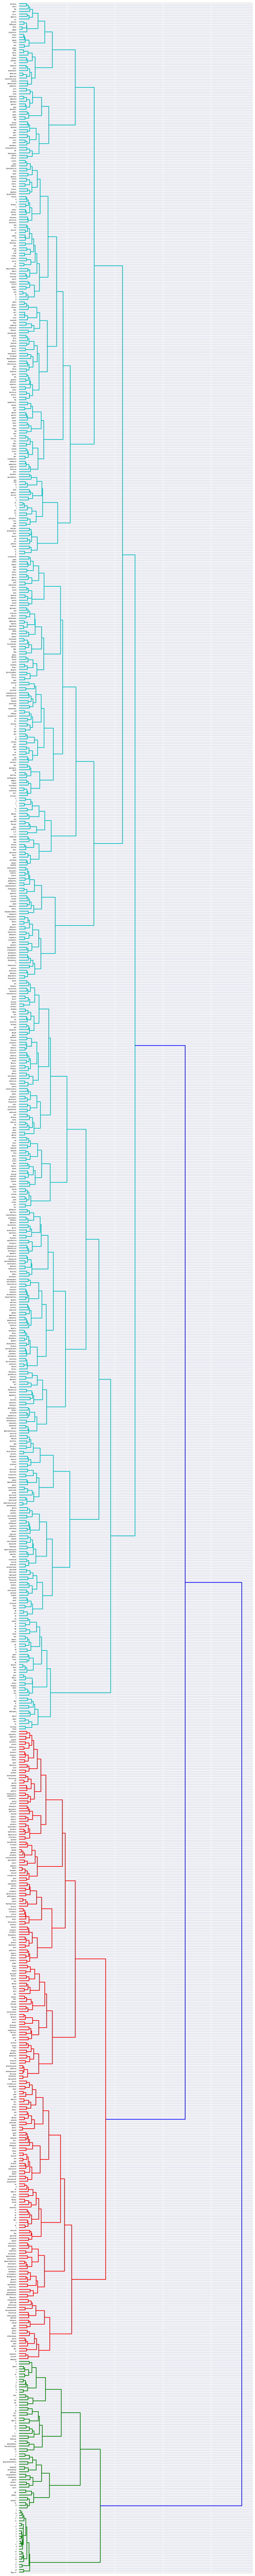

In [21]:
from scipy.cluster.hierarchy import  ward, dendrogram

linkage_matrix = ward(dist) 

fig, ax = plt.subplots(figsize=(10, 100)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=top_words);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() 

plt.savefig('w2v_cluster.png', dpi=200) #save figure as ward_clusters

## Классификация текстов 

По мотивам http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

In [22]:
X = df.text.tolist()
y = df.sent.tolist()

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

total train examples 151978
total test examples 74856


In [23]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(w2v.popitem()[1])

    def fit(self, X, y):
        return self

    def transform(self, X):
#         your
#         code
#         here

In [24]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(w2v.popitem()[1])

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
#         your
#         code
#         here

In [25]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rfc_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])
rfc_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])

In [27]:
rfc_w2v.fit(X_train,y_train)
pred = rfc_w2v.predict(X_test)

Precision:   0.77
Recall:   0.77
F1-measure:   0.77
Accuracy:   0.77
             precision    recall  f1-score   support

        neg       0.75      0.80      0.78     36847
        pos       0.80      0.74      0.77     38009

avg / total       0.77      0.77      0.77     74856



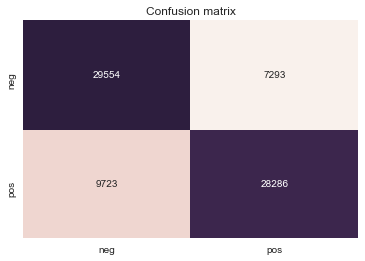

In [28]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [29]:
rfc_w2v_tfidf.fit(X_train,y_train)
pred = rfc_w2v_tfidf.predict(X_test)

Precision:   0.82
Recall:   0.82
F1-measure:   0.82
Accuracy:   0.82
             precision    recall  f1-score   support

        neg       0.80      0.84      0.82     36847
        pos       0.84      0.79      0.81     38009

avg / total       0.82      0.82      0.82     74856



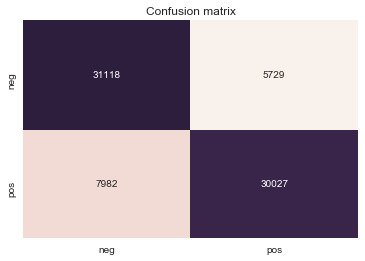

In [30]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

## doc2vec


word2vec с дополнительной меткой id документа

![img](img/w2v_4.png)

In [31]:
from gensim.models.doc2vec import *

In [32]:
splitted_texts = [text.split() for text in X]
idx = [str(i) for i in range(len(X))]

docs = []
for i in range(len(X)):
    docs.append(TaggedDocument(splitted_texts[i], [idx[i]]))


model = Doc2Vec(size=300, window=5, min_count=5, workers=8, alpha=0.025, min_alpha=0.01, dm=0)
model.build_vocab(docs)
model.train(docs, total_examples=len(docs), epochs=20)

In [33]:
class Doc2VecVectorizer(object):
    def __init__(self, d2v_model):
        self.d2v_model = d2v_model


    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([self.d2v_model.infer_vector(text.split()) for text in X])


rfc_d2v = Pipeline([
    ("word2vec vectorizer", Doc2VecVectorizer(model)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])

rfc_d2v.fit(X_train,y_train)
pred = rfc_d2v.predict(X_test)

Precision:   0.63
Recall:   0.63
F1-measure:   0.63
Accuracy:   0.63
             precision    recall  f1-score   support

        neg       0.61      0.68      0.64     36847
        pos       0.65      0.58      0.62     38009

avg / total       0.63      0.63      0.63     74856



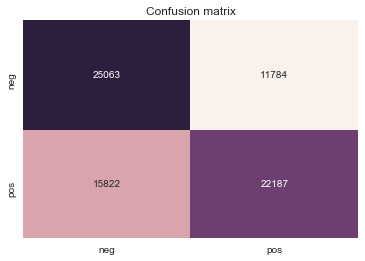

In [34]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

## fasttext 

Слово $w$ представляем символьными $n$-грамами: 

$n=3$, $G_{where} = \_wh, whe, her, re\_, \_where\_$

$sim_{w2v}(u,v) = <u,v>$


$ sim_{ft} (u,v) = \sum_{e \in G_u} \sum_{g \in G_v} <e,v>$


https://github.com/facebookresearch/fasttext

In [35]:
import fasttext

with open('data.train.txt', 'w+') as outfile:
    for i in range(len(X_train)):
        outfile.write('__label__' + y_train[i] + ' '+ X_train[i] + '\n')
    

with open('test.txt', 'w+') as outfile:
    for i in range(len(X_test)):
        outfile.write('__label__' + y_test[i] + ' ' + X_test[i] + '\n')

In [36]:
classifier = fasttext.supervised('data.train.txt', 'model')
result = classifier.test('test.txt')
print('P@1:', result.precision)
print('R@1:', result.recall)
print('Number of examples:', result.nexamples)

P@1: 0.917922411029176
R@1: 0.917922411029176
Number of examples: 74856


Precision:   0.92
Recall:   0.92
F1-measure:   0.92
Accuracy:   0.92
             precision    recall  f1-score   support

        neg       0.92      0.92      0.92     36847
        pos       0.92      0.92      0.92     38009

avg / total       0.92      0.92      0.92     74856



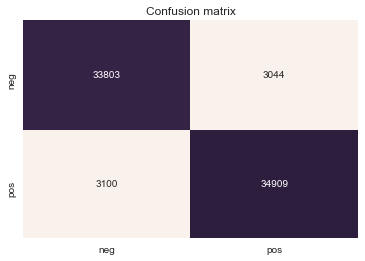

In [38]:
pred = classifier.predict(X_test)


print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, [i[0] for i in pred]))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()